In [19]:
import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from einops import rearrange
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as tf_layers
from tensorflow.keras.datasets.fashion_mnist import load_data as load_data_Fashion_MNIST
from tensorflow.keras.datasets.cifar10 import load_data as load_data_CIFAR_10

from nn.losses import *
from nn.layers import *
from nn.initializers import *
from nn.activations import *
from nn.network import NeuralNetwork, MulticlassNNClassifier

In [3]:
%load_ext autoreload

In [4]:
%autoreload

## Utility functions

In [9]:
def print_sizes(dataset):
    for subset in ['train', 'test']:
        for part in ['x', 'y']:
            print(f'{subset:>5} {part} - {dataset[subset][part].shape}')

In [10]:
def plot_random_images(images):
    chosen_images = random.choices(images, k=16)
    joined_image = rearrange(chosen_images, '(nh nw) h w c -> (nh h) (nw w) c', nw=4)
    cmap = 'gray' if images.shape[-1] == 1 else None
    plt.imshow(joined_image, cmap=cmap)

## Fashion MNIST

### Loading data

In [52]:
(x_train_fmnist, y_train_fmnist), (x_test_fmnist, y_test_fmnist) = load_data_Fashion_MNIST()

fmnist = {
    'train': {
        'x': x_train_fmnist[..., np.newaxis] / 255.0,
        'y': y_train_fmnist
    },
    'test': {
        'x': x_test_fmnist[..., np.newaxis] / 255.0,
        'y': y_test_fmnist
    }
}

In [53]:
print_sizes(fmnist)

train x - (60000, 28, 28, 1)
train y - (60000,)
 test x - (10000, 28, 28, 1)
 test y - (10000,)


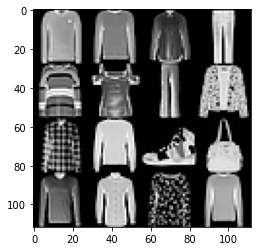

In [54]:
plot_random_images(fmnist['train']['x'])

### Tensorflow

### This library

## CIFAR 10

### Loading data

In [57]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = load_data_CIFAR_10()

cifar10 = {
    'train': {
        'x': x_train_cifar10 / 255,
        'y': y_train_cifar10
    },
    'test': {
        'x': x_test_cifar10 / 255,
        'y': y_test_cifar10
    }
}

In [38]:
print_sizes(cifar10)

train x - (50000, 32, 32, 3)
train y - (50000, 1)
 test x - (10000, 32, 32, 3)
 test y - (10000, 1)


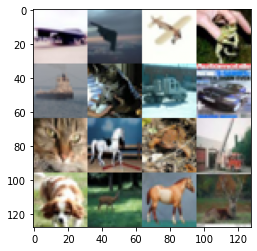

In [65]:
plot_random_images(cifar10['train']['x'])

### Tensorflow

### This library

## 20 class dataset

### Loading data

In [6]:
ds = tf.keras.utils.image_dataset_from_directory(
    'data/cars',
    color_mode='rgb',
    label_mode='int',
    shuffle=True,
    seed=42,
    image_size=(224, 224),
)

x_cars, y_cars = zip(*ds)
x_cars = np.concatenate(x_cars).astype(int) / 255
y_cars = np.concatenate(y_cars)

x_train_cars, x_test_cars, y_train_cars, y_test_cars = train_test_split(
    x_cars,
    y_cars,
    test_size=0.20,
    random_state=42
)

cars = {
    'train': {
        'x': x_train_cars,
        'y': y_train_cars,
        'y_hot': tf.one_hot(y_train_cars, 20)
    },
    'test': {
        'x': x_test_cars,
        'y': y_test_cars,
        'y_hot': tf.one_hot(y_test_cars, 20)
    }
}

Found 3235 files belonging to 20 classes.


In [11]:
print_sizes(cars)

train x - (2588, 224, 224, 3)
train y - (2588,)
 test x - (647, 224, 224, 3)
 test y - (647,)


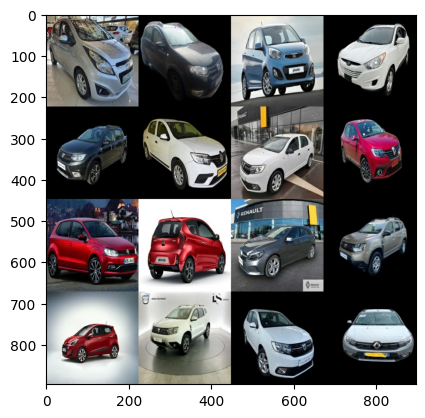

In [12]:
plot_random_images(cars['train']['x'])

### Tensorflow

In [13]:
tf_model_cars = keras.models.Sequential([
    tf_layers.InputLayer((224,224,3)),
    tf_layers.Conv2D(16, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(32, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Conv2D(64, 3, padding='valid', activation='relu'),
    tf_layers.MaxPooling2D(),
    tf_layers.Flatten(),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(128, activation='relu'),
    tf_layers.Dropout(0.2),
    tf_layers.Dense(20 , activation = 'softmax')
])

tf_model_cars.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

In [14]:
tf_model_cars.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

In [15]:
history = tf_model_cars.fit(
    cars['train']['x'],
    cars['train']['y_hot'],
    validation_data=(cars['test']['x'], cars['test']['y_hot']),
    epochs=15,
    batch_size=64,
)

Epoch 1/15
41/41 [==============================] - 9s 102ms/step - loss: 2.9144 - categorical_accuracy: 0.1009 - val_loss: 2.8611 - val_categorical_accuracy: 0.1360
Epoch 2/15
41/41 [==============================] - 3s 73ms/step - loss: 2.6707 - categorical_accuracy: 0.1909 - val_loss: 2.6000 - val_categorical_accuracy: 0.2380
Epoch 3/15
41/41 [==============================] - 3s 69ms/step - loss: 2.2236 - categorical_accuracy: 0.3304 - val_loss: 2.2211 - val_categorical_accuracy: 0.3354
Epoch 4/15
41/41 [==============================] - 3s 68ms/step - loss: 1.5718 - categorical_accuracy: 0.5232 - val_loss: 1.7806 - val_categorical_accuracy: 0.4915
Epoch 5/15
41/41 [==============================] - 3s 71ms/step - loss: 0.9495 - categorical_accuracy: 0.7040 - val_loss: 1.4380 - val_categorical_accuracy: 0.6105
Epoch 6/15
41/41 [==============================] - 3s 69ms/step - loss: 0.5048 - categorical_accuracy: 0.8447 - val_loss: 1.1817 - val_categorical_accuracy: 0.6971
Epoch 7/1

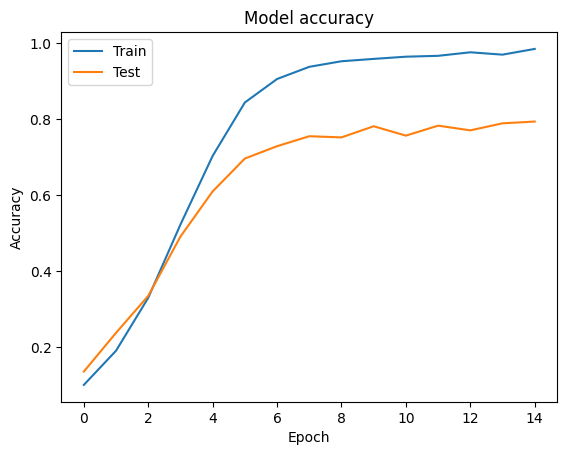

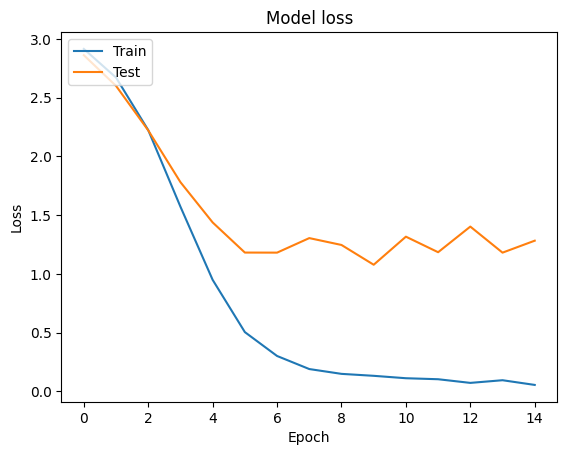

In [23]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

21/21 [==============================] - 0s 11ms/step
              precision    recall  f1-score   support

           0       0.86      0.62      0.72        29
           1       1.00      0.75      0.86        20
           2       0.62      0.84      0.71        25
           3       0.85      0.91      0.88        32
           4       0.89      0.88      0.89        66
           5       0.84      0.89      0.86        54
           6       0.81      0.78      0.79        27
           7       0.87      0.74      0.80        27
           8       0.79      0.94      0.86        32
           9       0.64      0.80      0.71        51
          10       1.00      0.88      0.93         8
          11       0.92      0.92      0.92        13
          12       0.85      0.66      0.74        35
          13       0.67      0.73      0.70        30
          14       0.67      0.55      0.60        33
          15       0.81      0.79      0.80        56
          16       0.80    

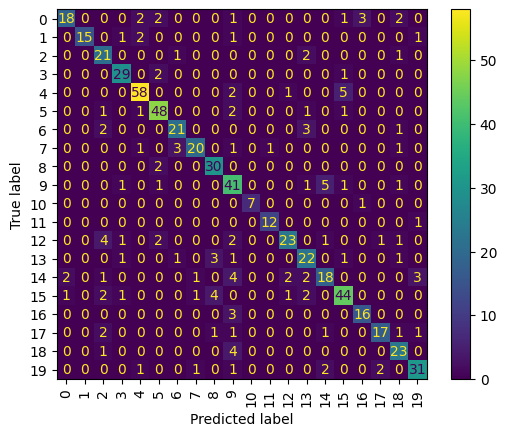

In [22]:
predictions = tf_model_cars.predict(cars['test']['x'])
true_classes = cars['test']['y']
predicted_classes = np.argmax(predictions, axis=1)

report = classification_report(true_classes, predicted_classes)
cm = confusion_matrix(true_classes, predicted_classes)

print(report)
ConfusionMatrixDisplay.from_predictions(
    true_classes, 
    predicted_classes, 
    xticks_rotation='vertical',
);

### This library